In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from data_import import etfs_merged
plt.style.use("dark_background")
def leastsquares(A, b):
    import numpy.linalg as npl
    # just a helper function to wrap the built-in leastsquares call
    return npl.lstsq(A, b, rcond=None)[0]

1999-03-10 00:00:00
                Volume  % Change % change binned  TMAX  TMIN  TOTALPRCP binned
Date                                                                          
1999-03-10  11700414.0 -0.124666        positive    42    27       0.00    Low
1999-03-11  21670048.0 -0.247858        positive    40    26       0.00    Low
1999-03-12  19553768.0 -2.080007        positive    39    24       0.00    Low
1999-03-15  14245348.0  2.108601        negative    41    32       4.37   High
1999-03-16  10971066.0  0.419432        negative    50    32       0.00    Low
...                ...       ...             ...   ...   ...        ...    ...
2017-11-06   9714451.5  0.195827        negative    66    46       0.01    Low
2017-11-07  10337675.5 -0.068213        positive    49    40       0.70    Low
2017-11-08   9011700.7  0.188292        negative    49    39       0.00    Low
2017-11-09  16871876.3  0.149131        negative    55    39       0.00    Low
2017-11-10   9777757.4  0.053403

In [2]:
negative = etfs_merged.loc[etfs_merged['% change binned'] == 'negative'].loc[:, ["TMAX", "TMIN", "TOTALPRCP"]].values.tolist()
positive = etfs_merged.loc[etfs_merged['% change binned'] == 'positive'].loc[:, ["TMAX", "TMIN", "TOTALPRCP"]].values.tolist()

etfs_data = {
    'positive' : positive, 'negative' : negative }

positive_total = len(positive)
negative_total = len(negative)
total_len = positive_total + negative_total


In [3]:
A = np.zeros((total_len, 3))
A[0:positive_total, :] = etfs_data['positive']
A[positive_total:total_len, :] = etfs_data['negative']
A = np.hstack([np.ones((total_len, 1)), A])

In [4]:
y = np.zeros((total_len,1))
y[0:positive_total] = 1 
y[positive_total:] = -1

In [5]:
x = leastsquares(A,y)
yhat = A @ x
yhat

array([[-0.04967906],
       [-0.04680099],
       [-0.05183288],
       ...,
       [-0.02308373],
       [-0.04465978],
       [-0.09093716]])

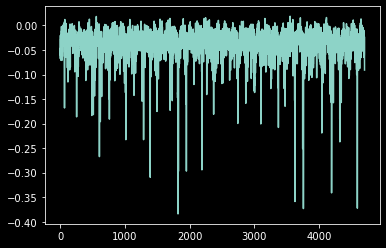

In [6]:
plt.plot(range(total_len), yhat)

In [7]:
y_n = np.zeros((total_len, 1))
y_n[0:positive_total] = -1
y_n[positive_total: total_len] = 1
x_n = leastsquares(A, y_n)
yhat_xn = A @ x_n

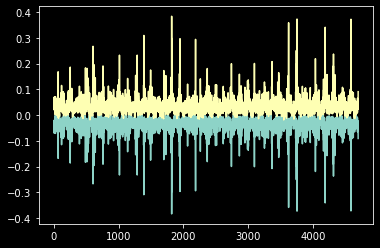

In [8]:
plt.plot(range(total_len),yhat, yhat_xn)

In [9]:
def fhat(row):
    y_positive = row @ x
    y_negative = row @ x_n
    outs = [y_positive, y_negative]
    if max(outs) == y_positive:
        return 'positive'
    else:
        return 'negative'

correct = ['positive'] * positive_total +  ['negative'] * negative_total

yhat_final = np.array([fhat(A[i, :]) for i in range(total_len)])
error_rate_final = sum(yhat_final != np.array(correct))/total_len


In [10]:
print(error_rate_final)

0.480961497553712


In [11]:
def sign(yhat):
    return 2.0 * (yhat > 0) - 1.0

"""Function definitions for Performance metrics, from Table 14.1 and pg.287 in Introduction to Applied Linear Algebra"""

def error_rate(y,yhat,total_len):
    sum_fpfn = 0
    for i in range(total_len):
        if y[i] !=sign(yhat[i]):
            sum_fpfn += 1
    return sum_fpfn/total_len

def true_positive(y,yhat,total_len):
    sum_tp = 0
    sum_p = 0
    for i in range(total_len):
        if y[i] == 1:
            sum_p += 1
            if sign(yhat[i]) == 1:
                sum_tp += 1
    return sum_tp/sum_p
        
def false_positive(y,yhat,total_len):
    sum_fp = 0
    sum_n = 0
    for i in range(total_len):
        if y[i] != 1:
            sum_n += 1
            if sign(yhat[i]) == 1:
                sum_fp += 1
    return sum_fp/sum_n

def true_negative(y,yhat,total_len):
    sum_tn = 0
    sum_n = 0
    for i in range(total_len):
        if y[i] != 1:
            sum_n += 1
            if sign(yhat[i]) !=1:
                sum_tn += 1
    return sum_tn/sum_n
         
def precision(y,yhat,total_len):
    sum_tp = 0
    sum_fp = 0
    for i in range(total_len):
        if y[i] == 1 and sign(yhat[i]) == 1:
            sum_tp += 1
        if y[i] != 1 and sign(yhat[i]) == 1:
            sum_fp += 1
    return sum_tp/(sum_tp + sum_fp)

In [12]:
print(error_rate(y,yhat,total_len), error_rate(y_n,yhat_xn,total_len))
print(true_positive(y,yhat,total_len), true_positive(y_n,yhat_xn,total_len))
print(false_positive(y,yhat,total_len), false_positive(y_n,yhat_xn,total_len))
print(true_negative(y,yhat,total_len), true_negative(y_n,yhat_xn,total_len))
print(precision(y,yhat,total_len), precision(y_n,yhat_xn,total_len))

0.480961497553712 0.480961497553712
0.03049049933716306 0.972518457752256
0.027481542247744052 0.9695095006628369
0.972518457752256 0.03049049933716306
0.5073529411764706 0.5193866374589267
